In [1]:
import os
import pickle
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model



In [2]:
def add_dim(x, shape):
    return np.reshape(x, (1,) + shape)

class QModelLSTM:
    def __init__(self, state_shape, n_action):
        self.state_shape = state_shape
        self.n_action = n_action
        self.qmodel = 'LSTM'
        self.attr2save = ['state_shape', 'n_action', 'model_name']
        self.init()

    def init(self):
        self.qmodel = 'LSTM'

    def build_model(self, n_hidden, dense_units, learning_rate, activation='relu'):
        model = keras.models.Sequential()
        model.add(keras.layers.Reshape((1,) + self.state_shape, input_shape=self.state_shape))  # Add an extra dimension for batch_size

        for i in range(len(n_hidden)):
            model.add(keras.layers.LSTM(n_hidden[i], return_sequences=(i < len(n_hidden) - 1)))

        for units in dense_units:
            model.add(keras.layers.Dense(units, activation=activation))

        model.add(keras.layers.Dense(self.n_action, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate))
        self.model = model
        self.model_name = self.qmodel + str(n_hidden) + str(dense_units)

    def save(self, fld):
        os.makedirs(fld)
        with open(os.path.join(fld, 'model.json'), 'w') as json_file:
            json_file.write(self.model.to_json())
        self.model.save_weights(os.path.join(fld, 'weights.hdf5'))

        attr = {a: getattr(self, a) for a in self.attr2save}
        pickle.dump(attr, open(os.path.join(fld, 'Qmodel_attr.pickle'), 'wb'))

    def load(self, fld, learning_rate):
        json_str = open(os.path.join(fld, 'model.json')).read()
        self.model = keras.models.model_from_json(json_str)
        self.model.load_weights(os.path.join(fld, 'weights.hdf5'))
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=learning_rate))

        attr = pickle.load(open(os.path.join(fld, 'Qmodel_attr.pickle'), 'rb'))
        for a in attr:
            setattr(self, a, attr[a])

    def predict(self, state):
        q = self.model.predict(add_dim(state, self.state_shape))[0]

        if np.isnan(max(q)):
            print('state' + str(state))
            print('q' + str(q))
            raise ValueError

        return q

    def fit(self, state, action, q_action):
        q = self.predict(state)

        # Flatten each array in q and concatenate them
        q_flat = np.concatenate([q_i.flatten() for q_i in q])

        # Check if q_action is an array
        if np.ndim(q_action) > 0:
            q_flat[action] = q_action  # Convert q_action to a scalar

        q_flat[action] = q_action

        self.model.fit(
            add_dim(state, self.state_shape),
            add_dim(q_flat, (self.n_action,)),
            epochs=1, verbose=0
        )
        

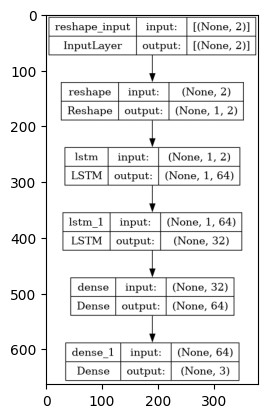

In [3]:
# Function to generate data based on given parameters
def generate_data(num_samples, temp_range, humidity_range, maintenance_times):
    states = []
    actions = []
    q_values = []

    for _ in range(num_samples):
        # Generate random state features
        temperature = np.random.uniform(*temp_range)
        humidity = np.random.uniform(*humidity_range)

        # Action is randomly selected for demonstration purposes
        action = np.random.choice([0, 1, 2])

        # Q-values are generated randomly for demonstration purposes
        q_value = np.random.rand(3)

        states.append([temperature, humidity])
        actions.append(action)
        q_values.append(q_value)

    return np.array(states), np.array(actions), np.array(q_values)

# Parameters
num_samples = 1000
temp_range = (20, 40)
humidity_range = (40, 80)
maintenance_times = np.random.choice([50, 100, 150], num_samples).astype(float)

# Generate synthetic data
states, actions, q_values = generate_data(num_samples, temp_range, humidity_range, maintenance_times)
df = pd.DataFrame({
    'temperature': states[:, 0],
    'humidity': states[:, 1],
    'action': actions,
    'q_value1': q_values[:, 0],
    'q_value2': q_values[:, 1],
    'q_value3': q_values[:, 2],
})

# Save data to CSV
csv_file_path = 'machine_data.csv'
df.to_csv(csv_file_path, index=False)

# Load your data from CSV
df = pd.read_csv(csv_file_path)

# Extract relevant columns
state_columns = ['temperature', 'humidity']
action_column = 'action'
q_value_columns = ['q_value1', 'q_value2', 'q_value3']

# Extract data from DataFrame
states = df[state_columns].values
actions = df[action_column].values
q_values = df[q_value_columns].values

# Create QModelLSTM
state_shape = states.shape[1:]  # Assuming the shape of each state
n_action = len(q_value_columns)  # Number of actions
q_model = QModelLSTM(state_shape, n_action)

# Build the model
q_model.build_model(n_hidden=[64, 32], dense_units=[64], learning_rate=0.001)

plot_model(q_model.model, to_file='q_model_lstm.png', show_shapes=True, show_layer_names=True)

# Display the image
img = plt.imread('q_model_lstm.png')
plt.imshow(img)
plt.show()


In [4]:
# Train the model
for i in range(len(df)):
    for j in range(len(q_values[i])):
        q_model.fit(states[i], actions[i], q_values[i, j])


# Save the model
q_model.save('path_to_save_model')

# Load the model
loaded_q_model = QModelLSTM(state_shape, n_action)
loaded_q_model.load('path_to_save_model', learning_rate=0.001)

# Example prediction
example_state = np.array([[25.0, 60.0]])  # Adjust with your own state
prediction = loaded_q_model.predict(example_state)
print("Q-values for the example state:", prediction)

1/1 [==============================] - 1s 872ms/step
Q-values for the example state: [0.37900805 0.5007212  0.4698782 ]


In [5]:
!git clone https://github.com/DnTrung/reinforcement.git

Cloning into 'reinforcement'...
